In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
}

Following is the Dummy GPT Model

1. Token Embedding Layer
```
self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
Learns a vector for each token ID (word index).
```
Converts (batch_size, seq_length) → (batch_size, seq_length, emb_dim).

2. Positional Embedding Layer
```
self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
```
Adds position info (like token 0, 1, 2...) to the input tokens.

3. Dropout
```
self.drop_emb = nn.Dropout(cfg["drop_rate"])
```
Adds regularization (randomly zeroes out parts of embedding during training).

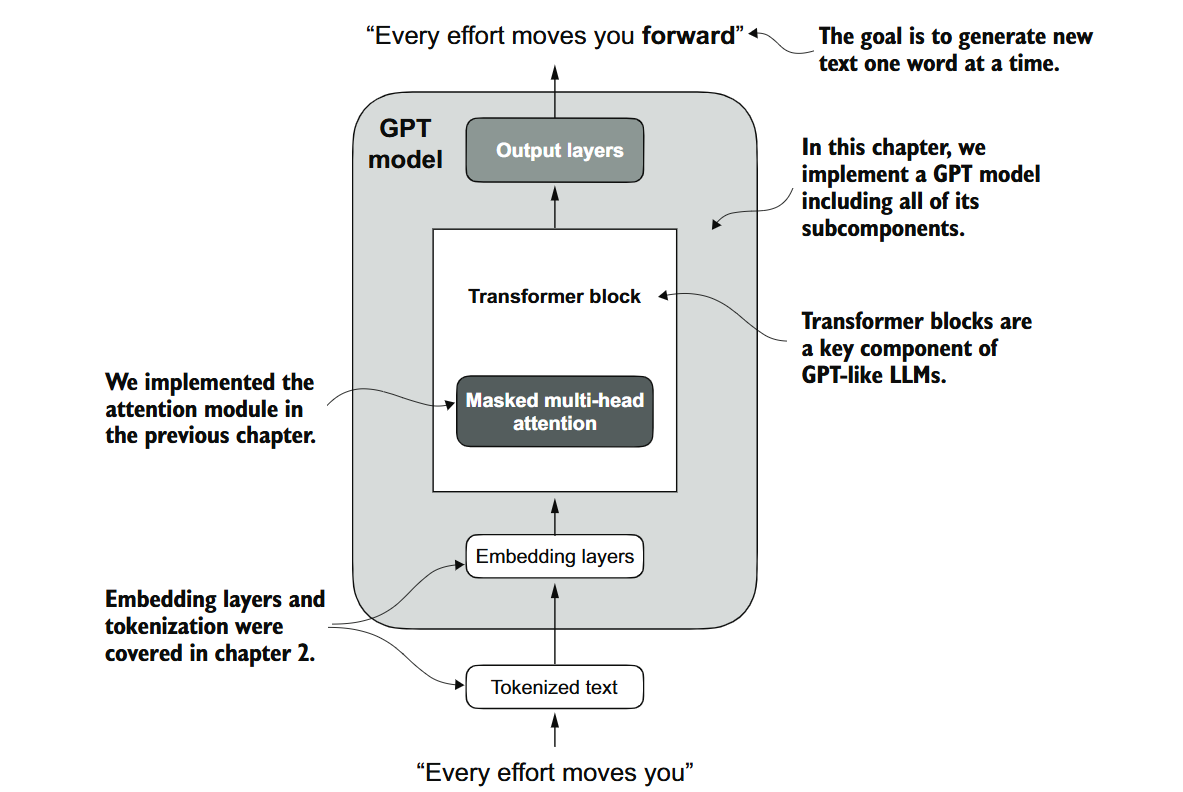

In [2]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb= nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb= nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb= nn.Dropout(cfg["drop_rate"])

        # use a placeholder for the transformer block
        self.trf_blocks= nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        # use a placeholder for LayerNorm
        self.final_norm= DummyLayerNorm(cfg["emb_dim"])
        self.out_head= nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=cfg["qkv_bias"]
        )

    def forward(self, in_idx):
        batch_size, seq_length= in_idx.shape
        tok_embeds= self.tok_emb(in_idx)
        pos_embeds= self.pos_emb(torch.arange(seq_length, device=in_idx.device))
        x= tok_embeds + pos_embeds
        x= self.drop_emb(x)
        x= self.trf_blocks(x)
        x= self.final_norm(x)
        logits= self.out_head(x)

        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # a simple placeholder

    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        

    def forward(self, x):
        return x



In [3]:
import tiktoken

tokenizer= tiktoken.get_encoding("gpt2")

batch= []

txt1= "Every effort moves you"
txt2= "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch= torch.stack(batch, dim=0)
batch.shape, print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


(torch.Size([2, 4]), None)

In [4]:
torch.manual_seed(123)
model= DummyGPTModel(cfg=GPT_CONFIG_124M)

logits= model(batch)
print("Outputs Shape: ",logits.shape)  
print("Logits: ", logits)

Outputs Shape:  torch.Size([2, 4, 50257])
Logits:  tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


### Normalization Activations with layer Normalizations

In [5]:
torch.manual_seed(123)

batch_example= torch.randn(1, 2, 5)
batch_example

tensor([[[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
         [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]]])

get a output from sequential layers

In [6]:
layer= nn.Sequential(nn.Linear(5,6),          # 5 is projected into 6
                     nn.ReLU())
out= layer(batch_example)
out

tensor([[[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
         [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]]],
       grad_fn=<ReluBackward0>)

In [7]:
out.shape

torch.Size([1, 2, 6])

normalizing across the last dimension (usually the feature vector dimension)

```
mean-> 0.00
var-> 1.00
```

In [8]:
mean= out.mean(-1, keepdim=True)
var= out.var(-1, keepdim=True)
mean, var

(tensor([[[0.1324],
          [0.2170]]], grad_fn=<MeanBackward1>),
 tensor([[[0.0231],
          [0.0398]]], grad_fn=<VarBackward0>))

to prevent any unnecessary stuff like-> (5,5,5,5,5) vala scene

In [9]:
(out-mean).mean(dim=-1, keepdim=True)
# should have been both 0.. but well its pretty close

tensor([[[-2.4835e-09],
         [ 0.0000e+00]]], grad_fn=<MeanBackward1>)

doing the normalization

In [10]:
normed= ((out-mean)/torch.sqrt(var))
normed.var(dim=-1, keepdim=True)

tensor([[[1.0000],
         [1.0000]]], grad_fn=<VarBackward0>)

Making a class out of it

In [11]:
torch.set_printoptions(sci_mode=False)

In [12]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps= 1e-5
        self.scale= nn.Parameter(torch.ones(emb_dim))
        self.shift= nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean= x.mean(dim=-1, keepdim= True)
        var= x.var(dim= -1, keepdim= True, unbiased= False)
        norm_x= (x-mean)/ torch.sqrt(var+ self.eps)
        return self.scale * norm_x + self.shift

Example walkthrough

In [13]:
out, out.shape     # unnormalized output


(tensor([[[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
          [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]]],
        grad_fn=<ReluBackward0>),
 torch.Size([1, 2, 6]))

pass the output through the layer Normalization function

In [14]:
ln= LayerNorm(emb_dim=6)
output_normed= ln(out)
output_normed, output_normed.shape

(tensor([[[ 0.6745,  1.5470, -0.9549,  0.6431, -0.9549, -0.9549],
          [-0.0207,  0.1228, -1.1913,  1.6619,  0.6186, -1.1913]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 2, 6]))

In [15]:
output_normed.mean(dim=-1, keepdim=True)
# comes pretty pretty close to 0

tensor([[[     0.0000],
         [    -0.0000]]], grad_fn=<MeanBackward1>)

In [16]:
output_normed.var(dim=-1, keepdim= True)

tensor([[[1.1994],
         [1.1996]]], grad_fn=<VarBackward0>)

ig there is some issue here... it should ideally come to be a perfect 1(var) and a perfect 0(mean)

### Implementing a Feed Forward Network using GELU activations

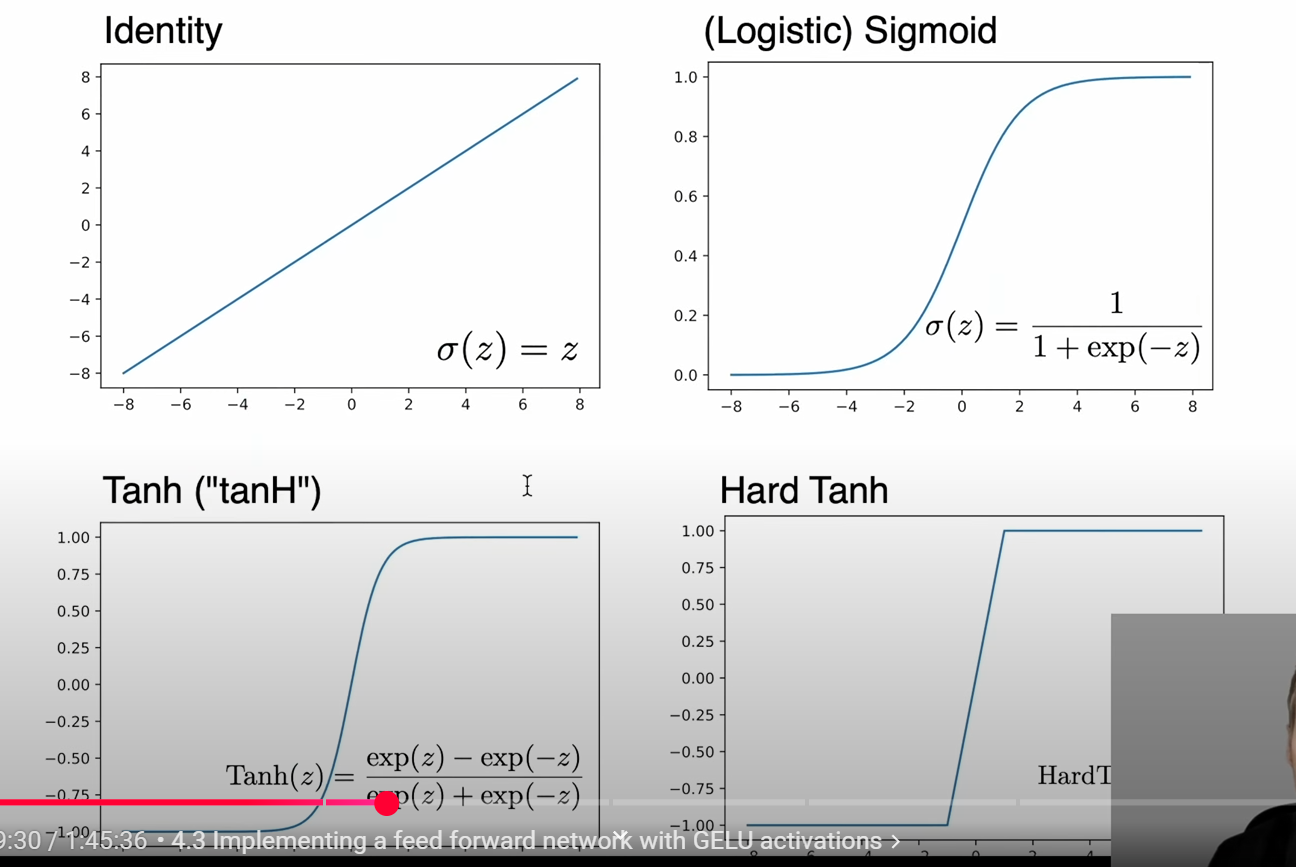

![Screenshot 2025-07-20 104623.png](<attachment:Screenshot 2025-07-20 104623.png>)
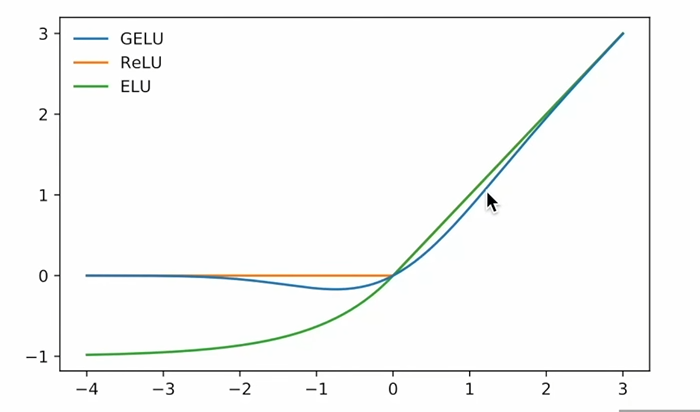

![Screenshot 2025-07-20 104327.png](<attachment:Screenshot 2025-07-20 104327.png>)
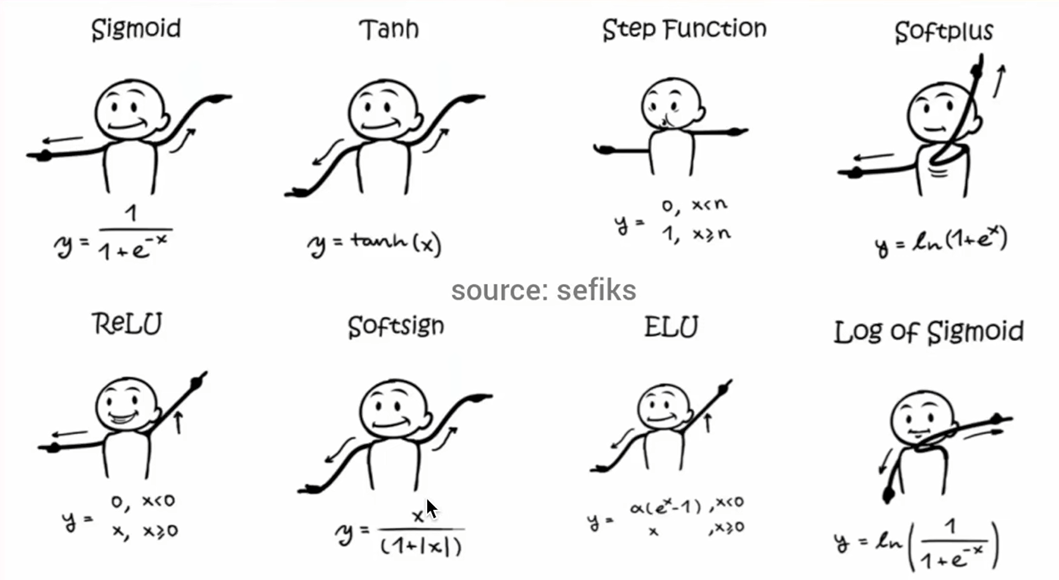

![Screenshot 2025-07-20 104348.png](<attachment:Screenshot 2025-07-20 104348.png>)
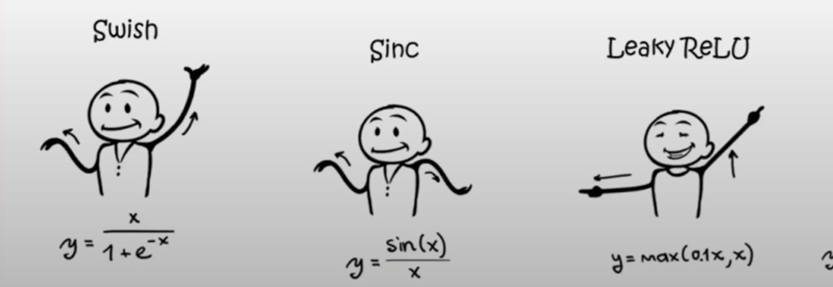

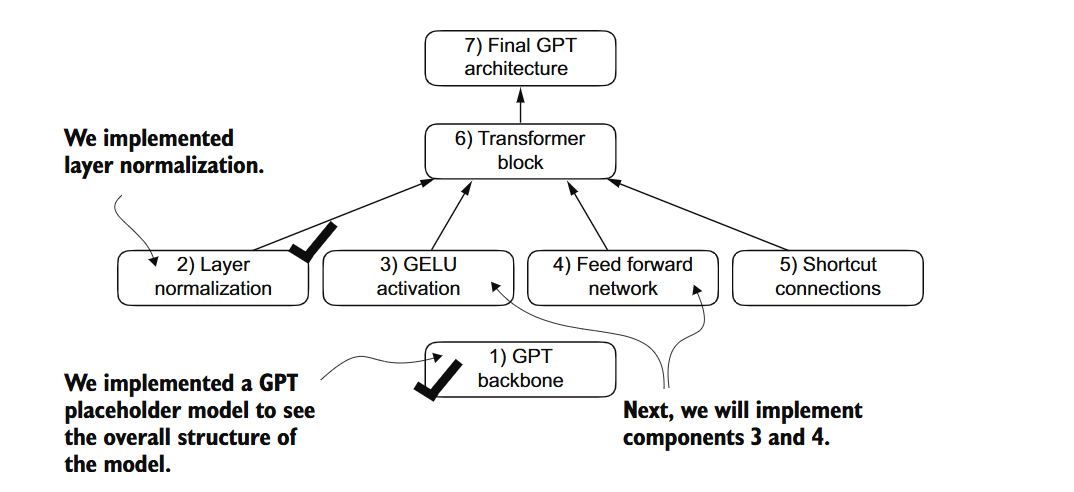

we are done with the layer normalization

proceeding to GELU activations. Can be any type of Non-Linearity

* GELU (Gaussian error linear unit) and SwiGLU(Swish-gated linear unit)

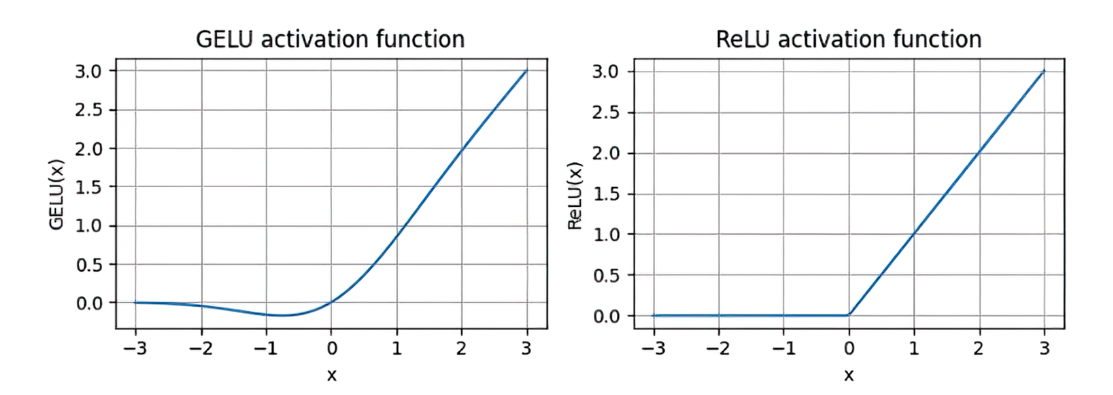

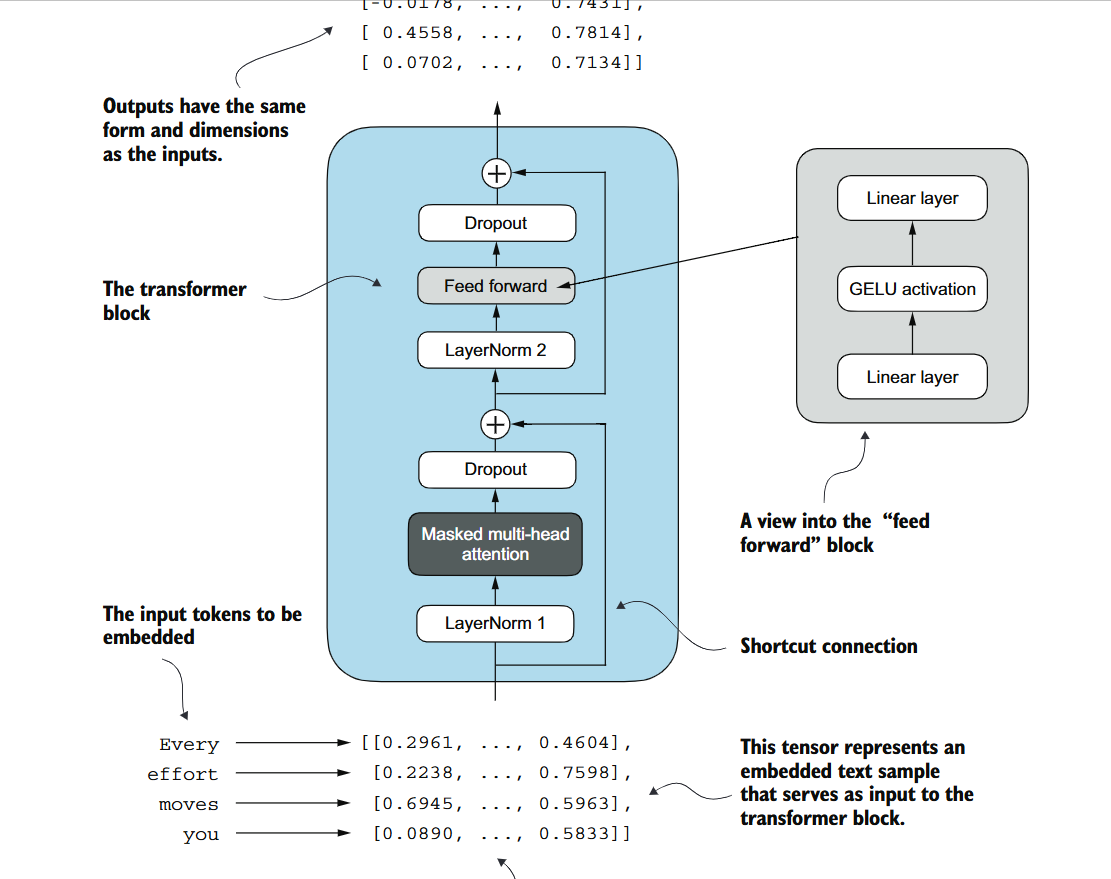

In [17]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

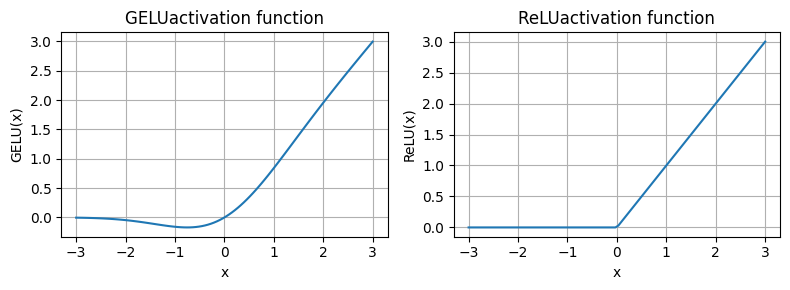

In [18]:
# just to show how all this looks like

import matplotlib.pyplot as plt

gelu, relu= GELU(), nn.ReLU()

# some sample data
x= torch.linspace(-3, 3 ,100)
y_gelu, y_relu= gelu(x), relu(x)

plt.figure(figsize=(8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]),1):
    plt.subplot(1, 2, i)
    plt.plot(x,y)
    plt.title(f"{label}activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid()

plt.tight_layout()
plt.show()

the feedforward network

In [19]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers= nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),      # 768-> 3072
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),      # 3072-> 768  
        )
    
    def forward(self, x):
        return self.layers(x)


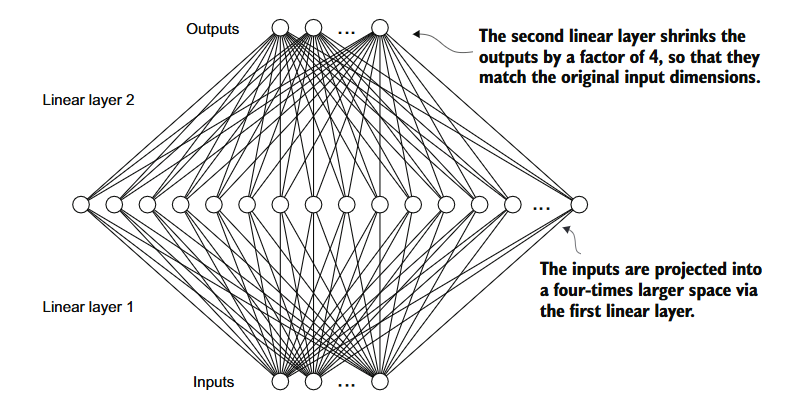

In [20]:
ffn= FeedForward(GPT_CONFIG_124M)
x= torch.rand(2, 3 , 768)
out=ffn(x)
out.shape

torch.Size([2, 3, 768])

### Adding Shortcut

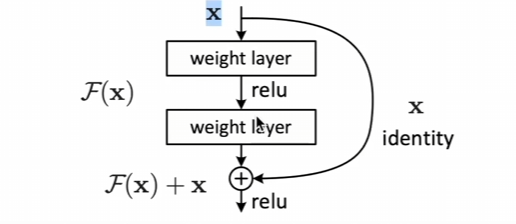

* also known as skip or residual connections
*  shortcut connection creates an alternative,  shorter pathfor the gradient to flow through the network by skipping one or more layers,
* It is achieved by adding the output of one layer to the output of a later layer. 

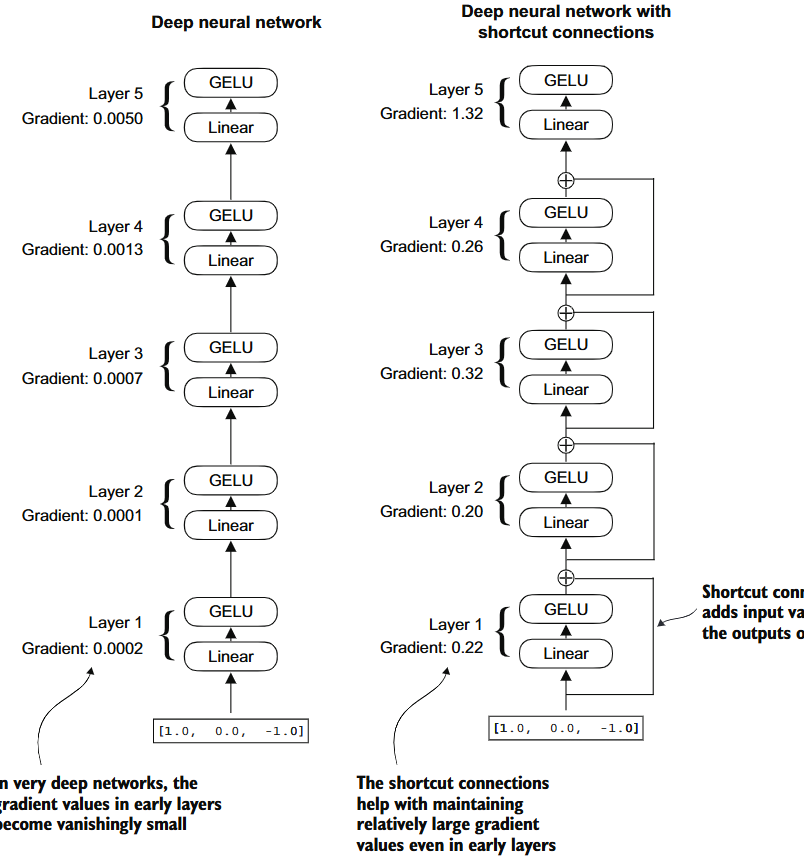

In [21]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers=nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1],layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # compute the output of the current layer
            layer_output= layer(x)
            # check if shortcut can be applied
            if self.use_shortcut and x.shape== layer_output.shape:
                x= x + layer_output
            else:
                x = layer_output
        return x

In [22]:
def print_gradients(model, x):

    # forward pass
    output= model(x)
    target= torch.tensor([[0.]])

    # calculate the loss based on how close the target and output are
    loss = nn.MSELoss()
    loss= loss(output, target)

    # backward pass to calculate the gradients
    loss.backward()


    for name, param in model.named_parameters():
        if 'weight' in name:

            # print the mean absolute gradient of the weight
            print(f"{name} had gradient mean of {param.grad.abs().mean().item()}")
 

In [23]:
torch.manual_seed(123)
layer_sizes= [3,3,3,3,3,1]
# initiate the model with the layer sizes
model= ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)

# get the input token vector
sample_input= torch.tensor([-1., 0., 1.])

print_gradients(model, sample_input)


layers.0.0.weight had gradient mean of 0.022350553423166275
layers.1.0.weight had gradient mean of 0.04712464660406113
layers.2.0.weight had gradient mean of 0.027912266552448273
layers.3.0.weight had gradient mean of 0.013673191890120506
layers.4.0.weight had gradient mean of 0.23397447168827057


c:\Users\think\Udemy\Rasbt\.venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


now doing it without useShortcut

In [24]:
torch.manual_seed(123)
layer_sizes= [3,3,3,3,3,1]
# initiate the model with the layer sizes
model= ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

# get the input token vector
sample_input= torch.tensor([-1., 0., 1.])

print_gradients(model, sample_input)

layers.0.0.weight had gradient mean of 0.0002546172763686627
layers.1.0.weight had gradient mean of 8.308068208862096e-05
layers.2.0.weight had gradient mean of 0.0007468178519047797
layers.3.0.weight had gradient mean of 0.001237659715116024
layers.4.0.weight had gradient mean of 0.004640599712729454


as we an see there is a huge diffence between the two

# Connecting the attention and linear layers in a transformer block

the explanation for this is mentioned in teh previous chapter

In [25]:
from torch.utils.data import Dataset, DataLoader
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids= []
        self.target_ids= []

        # tokenize the text
        token_ids= tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # dont store trillions of tokens like this
        
        # create the sliding window
        for i in range(0, len(token_ids)-max_length, stride):
            input_chunk= token_ids[i:i+max_length]
            target_chunk= token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [26]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle= True, drop_last=True, num_workers=0):
    # these parameters can be overwritten 
    # batch_size: like how many samples are in our batch
    # max_length: the size of our context size [our box. at once]
    # stride: by how many places are we moving at once

    # initialize the tokenizer
    tokenizer= tiktoken.get_encoding("gpt2")

    # create the dataset
    dataset= GPTDatasetV1(txt, tokenizer, max_length, stride)

    # create the dataloader
    dataloader= DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=shuffle,    
        drop_last=drop_last,
        num_workers=num_workers
    )
    return dataloader

In [27]:
class MultiHeadAttentionClass(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias= False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
        self.d_out= d_out
        self.d_in= d_in
        self.num_heads= num_heads
        self.head_dim= d_out // num_heads # reduce the dimension of the output vector for each head
        
        self.W_query= torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key= torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value= torch.nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj= torch.nn.Linear(d_out, d_out, bias=qkv_bias)
        self.dropout= torch.nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))                # put one above and over the diagonal and rest 0


    def forward(self, x):
        b, num_tokens, d_in= x.shape

        keys= self.W_key(x)        # (2, 6, 3)-> (b, num_tokens, d_out)
        queries= self.W_query(x)
        values= self.W_value(x)

        # we now split the  matrix by adding a "num_heads" dimension
        # unroll last dim: (b, num_tokens, d_out)-> (b, nums_tokens, num_heads, head_dim)
        keys= keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries= queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values= values.view(b, num_tokens, self.num_heads, self.head_dim)

        # transpose-> (batch, self.num_heads, self.num_tokens, self.head_dim)
        keys= keys.transpose(1, 2)
        queries= queries.transpose(1, 2)
        values= values.transpose(1, 2)

        attn_scores= queries @ keys.transpose(2,3)         # (b, num_heads, num_tokens, head_dim) @ (b, num_heads, head_dim, num_tokens)

        # original mask truncated to the number of tokens and converted to boolean
        mask_bool= self.mask.bool()[:num_tokens, :num_tokens]

        # use the mask to set the upper triangle of the attention scores to -inf
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights= torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights= self.dropout(attn_weights)

        # shape: (b, num_heads, num_tokens, head_dim)
        context_vec= (attn_weights @ values). transpose(1, 2)

        # combine the heads, where self.d_out= self.num_heads * self.head_dim
        context_vec= context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec= self.out_proj(context_vec)     # optional projecton

        return context_vec

In [28]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers= nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),      # 768-> 3072
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),      # 3072-> 768  
        )
    
    def forward(self, x):
        return self.layers(x)


In [29]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.multiatt = MultiHeadAttentionClass(
            d_in= cfg["emb_dim"],
            d_out= cfg["emb_dim"],
            context_length= cfg["context_length"],  
            dropout= cfg["drop_rate"],
            num_heads= cfg["n_heads"],  
            qkv_bias= cfg["qkv_bias"]
        )  
        self.ff= FeedForward(cfg)
        self.norm1= LayerNorm(cfg["emb_dim"])
        self.norm2= LayerNorm(cfg["emb_dim"])
        self.drop_shortcut= nn.Dropout(cfg["drop_rate"])

    
    def forward(self, x):
        # shortcut connections for attention block
        shortcut= x
        x = self.norm1(x)
        x= self.multiatt(x)
        x= self.drop_shortcut(x)
        x= x + shortcut         # add the original input back

        # shortcut connections for feed forward block
        shortcut= x
        x= self.norm2(x)
        x= self.ff(x)
        x= self.drop_shortcut(x)
        x= x + shortcut         # add the original input back

        return x

In [30]:
torch.manual_seed(123)

x= torch.rand(2, 4, 768)
block= TransformerBlock(GPT_CONFIG_124M)
out= block(x)
out.shape, out

(torch.Size([2, 4, 768]),
 tensor([[[ 0.3110,  0.6988,  0.0345,  ...,  1.5609,  0.7526,  0.4869],
          [ 0.5515, -0.1763, -0.0076,  ...,  0.5177,  0.3721,  0.6320],
          [ 0.5628,  0.1592,  0.0479,  ...,  1.0993,  0.3239,  0.4245],
          [-0.2638,  0.7804,  0.5115,  ...,  0.7668,  0.4899,  0.5428]],
 
         [[ 0.0337,  0.5356,  0.1099,  ...,  0.3724,  0.3196, -0.0696],
          [-0.0855,  0.4489,  0.2067,  ...,  0.6980,  0.0771,  0.6215],
          [ 0.5284, -0.1347, -0.1536,  ...,  0.6008,  0.5952, -0.5505],
          [ 0.2500,  0.5422,  0.3655,  ...,  1.2397,  1.1822,  0.0229]]],
        grad_fn=<AddBackward0>))

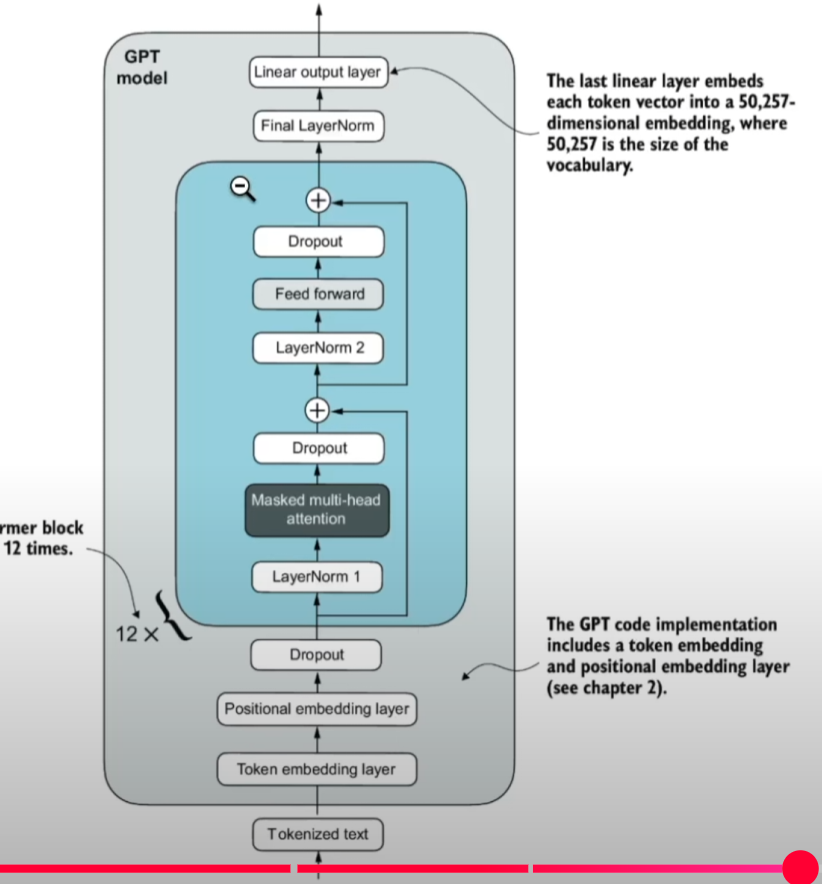

Okay so putting this transformer in the GPT block

In [31]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb= nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb= nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb= nn.Dropout(cfg["drop_rate"])

        self.trf_blocks= nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm= LayerNorm(cfg["emb_dim"])
        self.out_head= nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias= False
        )

    def forward(self, in_idx):
        batch_size, seq_length= in_idx.shape
        tok_embeds= self.tok_emb(in_idx)
        pos_embeds= self.pos_emb(torch.arange(seq_length, device=in_idx.device))

        x= tok_embeds + pos_embeds
        x= self.drop_emb(x)

        x= self.trf_blocks(x)

        x= self.final_norm(x)

        logits= self.out_head(x)

        return logits

In [32]:
import tiktoken

tokenizer= tiktoken.get_encoding("gpt2")

batch= []

txt1= "Every effort moves you"
txt2= "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

batch= torch.stack(batch, dim=0)

print("Batch Shape: ", batch.shape)
print("Batch: ", batch)

Batch Shape:  torch.Size([2, 4])
Batch:  tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [33]:
torch.manual_seed(123)
model= GPTModel(cfg=GPT_CONFIG_124M)
logits= model(batch)
logits, logits.shape  # (2, 6, 50257) -> (batch_size, num_tokens, vocab_size)

(tensor([[[-0.6273, -0.1458,  0.1839,  ..., -0.6657, -0.4855, -0.7900],
          [-0.2751, -0.7954, -0.5568,  ...,  0.0809, -0.3880, -0.5015],
          [ 0.3021,  0.2730,  0.0179,  ...,  0.5005, -0.1498,  0.5615],
          [-0.3155, -0.1602,  1.1678,  ...,  0.5601,  0.3108,  0.3132]],
 
         [[-0.7103, -0.2001,  0.0363,  ..., -0.2801, -0.5357, -0.6127],
          [-0.5182, -0.4019, -0.4059,  ..., -0.6950, -0.7436, -0.0123],
          [ 0.5663, -0.0498,  0.4945,  ..., -0.3452, -0.3020,  0.3400],
          [-0.1737, -0.5376,  0.7940,  ...,  0.7631,  0.3292,  0.2092]]],
        grad_fn=<UnsafeViewBackward0>),
 torch.Size([2, 4, 50257]))

In [34]:
total_params = sum(p.numel() for p in model.parameters())
print("Total Parameters: ", total_params)

Total Parameters:  163000320


### Generating the text out of this

In [35]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):

        idx_cond= idx[:, -context_size:]    # truncate the input to the last context_size tokens

        with torch.no_grad():
            logits= model(idx_cond)

        # get the last token's logits
        logits= logits[:, -1, :]

        probas= torch.softmax(logits, dim= -1)

        # idx_next= torch.multinomial(probas, num_samples=1)  # sample from the distribution

        idx_next= torch.argmax(probas, dim=-1, keepdim=True)  # take the most probable token

        idx= torch.cat((idx, idx_next), dim=1)

    return idx

In [36]:
start_context= "Hello I am"

encoded_text= tokenizer.encode(start_context)
batch= torch.tensor(encoded_text).unsqueeze(0)  # add batch dimension
batch.shape


model= GPTModel(cfg=GPT_CONFIG_124M)

out = generate_text_simple(model, 
                           idx= batch,
                           max_new_tokens=7,
                           context_size=GPT_CONFIG_124M["context_length"])

In [37]:
out

tensor([[15496,   314,   716, 38214,  4079, 28156, 21990, 27498, 40135, 49622]])

In [38]:
tokenizer.decode((out.squeeze(0)).tolist())

'Hello I am\\"> reflect� weighingeros Yamato litres'